<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Load-Data-and-Prepare-for-Training" data-toc-modified-id="Load-Data-and-Prepare-for-Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data and Prepare for Training</a></span></li><li><span><a href="#Define-Model-Architecture" data-toc-modified-id="Define-Model-Architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Model Architecture</a></span><ul class="toc-item"><li><span><a href="#Discriminator" data-toc-modified-id="Discriminator-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Discriminator</a></span></li><li><span><a href="#Generator" data-toc-modified-id="Generator-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generator</a></span></li><li><span><a href="#Combined-GAN" data-toc-modified-id="Combined-GAN-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Combined GAN</a></span></li></ul></li><li><span><a href="#Define-Helper-Functions" data-toc-modified-id="Define-Helper-Functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define Helper Functions</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

# Setup

In [ ]:
import csv
import datetime
import io
import os
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input, Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model, save_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from numpy import asarray, ones, zeros,  load, savez_compressed
from numpy.random import randn, randint
from scipy.io import loadmat
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (BatchNormalization, Concatenate, Conv2D, Conv2DTranspose, Dense, Dropout, Embedding, Flatten, LeakyReLU, Reshape)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! nvidia-smi

Tue Mar  7 15:54:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Data and Prepare for Training

In [ ]:
# load data

base_path = "/content/drive/MyDrive/inmates/"

images_train = load(base_path + 'data_arrays/train_images.npz')['arr_0']
bmi_train = load(base_path + 'data_arrays/bmi_train.npz', allow_pickle=True)['arr_0']

images_test = load(base_path + 'data_arrays/test_images.npz')['arr_0']
bmi_test = load(base_path + 'data_arrays/bmi_test.npz',allow_pickle=True)['arr_0']


print('Loaded: ', images_train.shape)
print('Loaded: ', bmi_train.shape)
print('Loaded: ', images_test.shape)
print('Loaded: ', bmi_test.shape)

Loaded:  (47999, 64, 64, 3)
Loaded:  (47999,)
Loaded:  (12000, 64, 64, 3)
Loaded:  (12000,)


In [ ]:
# round to nearest integer
bmi_train = np.round(bmi_train)

# convert to integers
bmi_train = bmi_train.astype(int)

bmi_train[0]

35

In [ ]:
# round to nearest integer
bmi_test = np.round(bmi_test)

# convert to integers
bmi_test = bmi_test.astype(int)

bmi_test[0]

22

# Define Model Architecture

## Discriminator

In [ ]:
def define_discriminator(in_shape=(64,64,3)):
    # define label input (single value)
    in_label = Input(shape=(1,))
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1] 
    # fully connected layer to generate a channel for the label input
    li = Dense(n_nodes)(in_label) 
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li) 

    # image input
    in_image = Input(shape=in_shape) 
    # concat label as a channel
    merge = Concatenate()([in_image, li]) 

    # downsample image
    # first convolutional layer
    fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(merge) 
    # apply leaky relu activation function
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # second convolutional layer
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) 
    # apply leaky relu activation function
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # third convolutional layer
    fe = Conv2D(256, (3,3), strides=(2,2), padding='same')(fe) 
    # apply leaky relu activation function
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # fourth convolutional layer
    fe = Conv2D(512, (3,3), strides=(2,2), padding='same')(fe) 
    # apply leaky relu activation function
    fe = LeakyReLU(alpha=0.2)(fe)

    # flatten feature maps
    fe = Flatten()(fe)
    # dropout to prevent overfitting
    fe = Dropout(0.4)(fe)
    # output layer with a single node and sigmoid activation
    out_layer = Dense(1, activation='sigmoid')(fe)  

    # define the model with image and label inputs and output
    model = Model([in_image, in_label], out_layer)
    # compile the model with binary cross-entropy loss and Adam optimizer
    opt = Adam(learning_rate=0.0004, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
discriminator = define_discriminator()
print(discriminator.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 4096)         8192        ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 reshape (Reshape)              (None, 64, 64, 1)    0           ['dense[0][0]']                  
                                                                                              

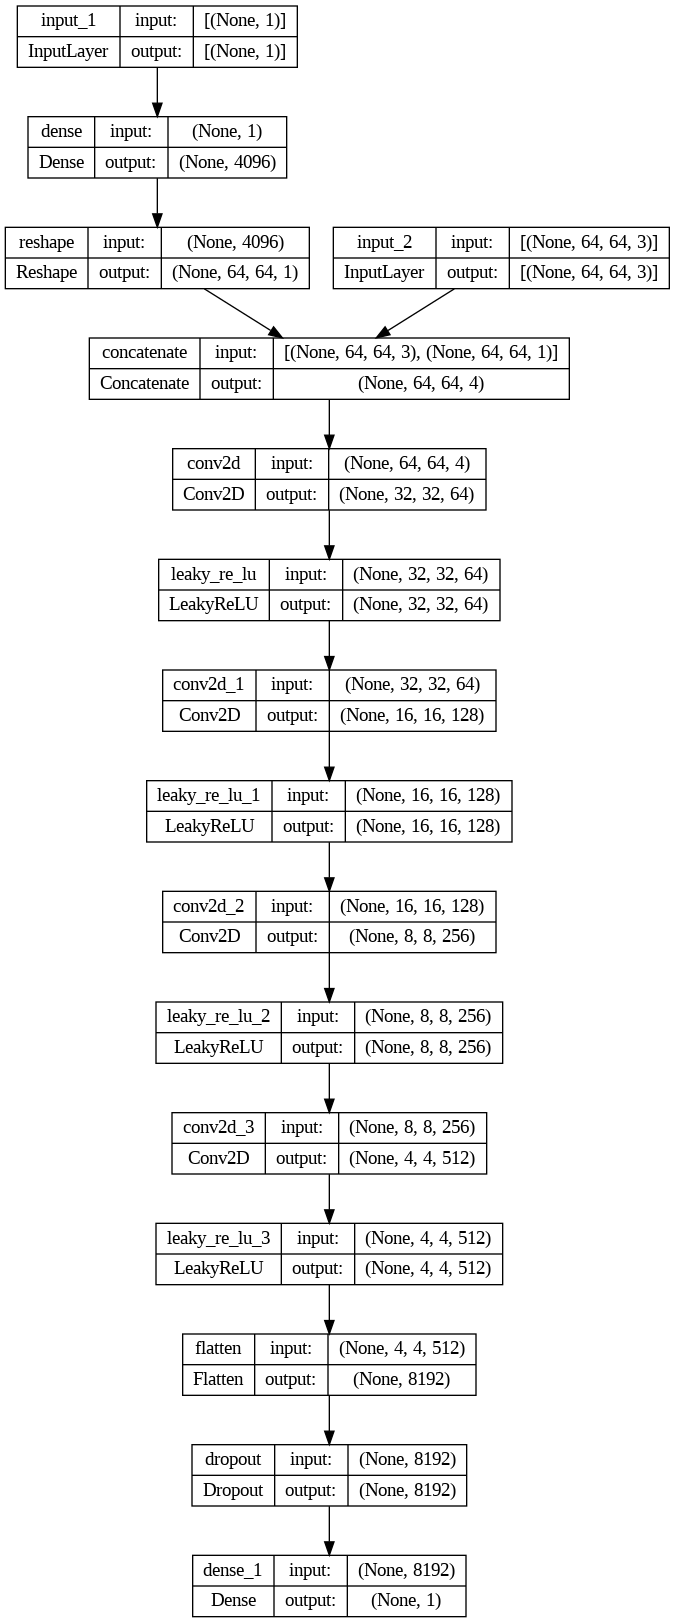

In [ ]:
# visualize the model architecture
plot_model(discriminator, show_shapes=True, show_layer_names=True)

## Generator

In [ ]:
latent_dim = 100

In [ ]:
def define_generator(latent_dim):
    # label input
    in_label = Input(shape=(1,))

    # linear multiplication
    n_nodes = 8 * 8
    li = Dense(n_nodes)(in_label)
    
    # reshape to additional channel
    li = Reshape((8, 8, 1))(li)

    # image generator input
    in_lat = Input(shape=(latent_dim,))

    # foundation for 8x8 image
    n_nodes = 256 * 8 * 8
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 256))(gen)

    # merge image gen and label input
    merge = Concatenate()([gen, li])

    # upsample to 16x16
    gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 64x64
    gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # output
    out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)

    # define model
    model = Model([in_lat, in_label], out_layer)

    return model

In [ ]:
generator = define_generator(latent_dim)
print(generator.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 16384)        1654784     ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 16384)        0           ['dense_3[0][0]']                
                                                                                            

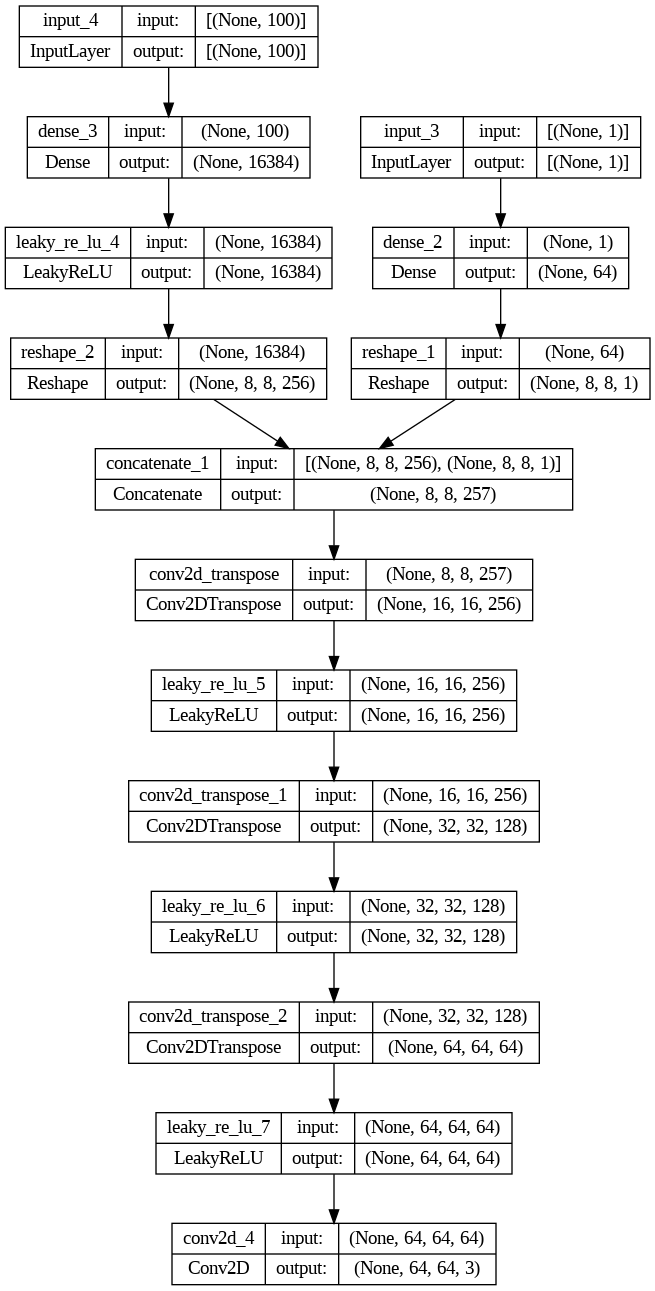

In [ ]:
# visualize the model architecture
plot_model(generator, show_shapes=True, show_layer_names=True)

## Combined GAN

In [ ]:
def define_gan(g_model, d_model):
    # Discriminator is trained separately -> So set to not trainable
    d_model.trainable = False  

    # connect generator and discriminator
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input  #Latent vector size and label size
    
    # get image output from the generator model
    gen_output = g_model.output  

    # generator image output and corresponding input label are inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
gan = define_gan(generator, discriminator)
print(gan.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 16384)        1654784     ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 16384)        0           ['dense_3[0][0]']                
                                                                                            

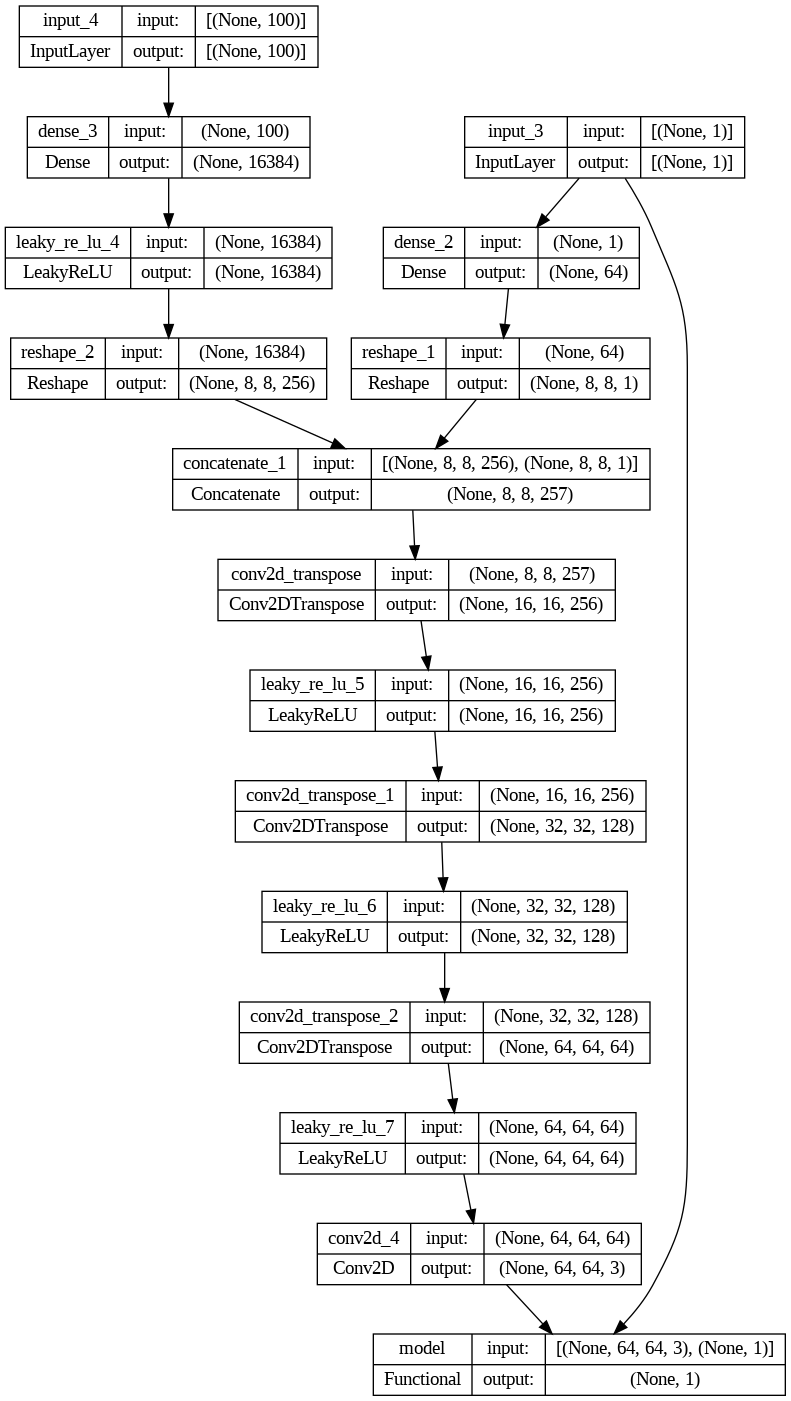

In [ ]:
# visualize the model architecture
plot_model(gan, show_shapes=True, show_layer_names=True)

# Define Helper Functions

In [ ]:
def load_real_samples():
    # load dataset
    trainX, trainy = images_train, bmi_train
    # convert to floats and scale
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1] to match the the output of generator
    X = (X - 127.5) / 127.5   
    return [X, trainy]

In [ ]:
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset  
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels and assign to y (1=real image)
    y = ones((n_samples, 1))
    return [X, labels], y

In [ ]:
def create_distribution_and_sample(array, n_samples):
    # Create a probability distribution from the array
    dist = np.array(array) / sum(array)
    # Draw n samples from the distribution
    sample_indices = np.random.choice(len(array), size=n_samples, p=dist)
    # Get the actual values corresponding to the sampled indices
    samples = [array[i] for i in sample_indices]
    return asarray(samples)

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = create_distribution_and_sample(bmi_train, n_samples)
    return [z_input, labels]

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels (0=fake image)
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [ ]:
def plot_to_image(figure):
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

In [ ]:
def generate_image_grid(model):
    # generate random points in the latent space
    latent_points, labels = generate_latent_points(100,100)

    # generate images from the latent points and labels using the generator model
    generated_images = model.predict([latent_points, labels])

    # scale the pixel values from [-1,1] to [0,255]
    generated_images = (generated_images + 1) / 2.0 * 255
    generated_images = generated_images.astype(np.uint8)

    # create a grid of subplots to display the generated images
    fig, axs = plt.subplots(10,10, figsize=(14,14))

    # iterate through each label and plot the corresponding image
    for i, (image, label) in enumerate(zip(generated_images, labels)):
        ax = axs[i//10, i%10]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"BMI {label}")

    plt.tight_layout()
    # plt.show()
    
    return fig

# Model Training

In [ ]:
# Define data augmentation parameters
data_augmentation = ImageDataGenerator(
    rotation_range=10, # degree range for random rotations
    horizontal_flip=True, # randomly flip inputs horizontally
    fill_mode='nearest' # how to fill in any new pixels created during the augmentation
)

In [ ]:
# Sets up a timestamped log directory for Tensorboard
log_dir = "logs/fit/"
# Creates a file writer for the log directory.
writer = tf.summary.create_file_writer(log_dir)

In [ ]:
# Create empty lists to hold loss values
mean_combined_loss_list = []
mean_d_loss_real_list = []
mean_d_loss_fake_list = []
mean_g_loss_list = []
mean_combined_acc_list = []
mean_acc_fake_list = []
mean_acc_real_list = []

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    # Determine number of batches per epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # Determine the number of samples in each half batch
    half_batch = int(n_batch / 2)

    # Manually enumerate epochs
    for i in range(n_epochs):

      # Create empty lists to hold loss values
        combined_loss_list = []
        d_loss_real_list = []
        d_loss_fake_list = []
        g_loss_list = []
        combined_acc_list = []
        acc_fake_list = []
        acc_real_list = []

        # Enumerate batches over the training set
        for j in range(bat_per_epo):
            # Train the discriminator on real and fake images, separately (half batch each)

            # Get randomly selected 'real' samples with labels
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # Apply data augmentation to the real samples
            X_real = data_augmentation.flow(X_real, batch_size=half_batch, shuffle=False).next()

            # Update discriminator model weights on the real samples
            d_loss_real, acc_real = d_model.train_on_batch([X_real, labels_real], y_real)

            # Generate 'fake' examples with labels
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            # Update discriminator model weights on the fake samples
            d_loss_fake, acc_fake = d_model.train_on_batch([X_fake, labels], y_fake)

            # Prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            # create array of real labels to fool the discriminator (hence value of 1 for y)
            y_gan = ones((n_batch, 1))

            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)  

            # compute total loss and accuracy
            combined_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            combined_acc = 0.5 * np.add(acc_real, acc_fake)

            # Append loss values to respective lists
            combined_loss_list.append(combined_loss)
            d_loss_real_list.append(d_loss_real)
            d_loss_fake_list.append(d_loss_fake)
            g_loss_list.append(g_loss)
            combined_acc_list.append(combined_acc)
            acc_fake_list.append(acc_fake)
            acc_real_list.append(acc_real)

            print("Epoch: ", i+1, "/", n_epochs, " Batch: ", j+1, "/", bat_per_epo)

            # Log losses to TensorBoard
            with writer.as_default():
                tf.summary.scalar('combined_loss', combined_loss, step=i)
                tf.summary.scalar('d_loss_real', d_loss_real, step=i)
                tf.summary.scalar('d_loss_fake', d_loss_fake, step=i)
                tf.summary.scalar('g_loss', g_loss, step=i)
                tf.summary.scalar('combined_acc', combined_acc, step=i)
                tf.summary.scalar('acc_fake', acc_fake, step=i)
                tf.summary.scalar('acc_real', acc_real, step=i)
                writer.flush()

        # Get mean values and append to other lists
        mean_combined_loss = np.mean(combined_loss_list)
        mean_d_loss_real = np.mean(d_loss_real_list)
        mean_d_loss_fake = np.mean(d_loss_fake_list)
        mean_g_loss = np.mean(g_loss_list)
        mean_combined_acc = np.mean(combined_acc_list)
        mean_acc_fake = np.mean(acc_fake_list)
        mean_acc_real = np.mean(acc_real_list)

        mean_combined_loss_list.append(mean_combined_loss)
        mean_d_loss_real_list.append(mean_d_loss_real)
        mean_d_loss_fake_list.append(mean_d_loss_fake)
        mean_g_loss_list.append(mean_g_loss)
        mean_combined_acc_list.append(mean_combined_acc)
        mean_acc_fake_list.append(mean_acc_fake)
        mean_acc_real_list.append(mean_acc_real)


        if (i+1) % 10 == 0:    
            # Prepare the plot
            figure = generate_image_grid(g_model)
            # save the figure
            figure.savefig('path/image_grids/image_grid_epoch_' + str(i) + '.png')
            # Convert to image and log
            with writer.as_default():
                tf.summary.image("Training data", plot_to_image(figure), step=i)

            # save the model with a different name for each epoch and include date and time
            now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            model_name = 'path/models/64/inmates_conditional_generator_V2_continous_epoch_' + str(i) + '_' + now + '.h5'
            g_model.save(model_name)

In [ ]:
# load image data
dataset = load_real_samples()

In [ ]:
# train model
train(generator, discriminator, gan, dataset, latent_dim, n_epochs=300)

In [ ]:
# Define file name
csv_file = 'mean_loss_and_acc.csv'

# Define headers
headers = ['Epoch', 'Combined Loss', 'D Loss Real', 'D Loss Fake', 'G Loss', 'Combined Acc', 'Acc Fake', 'Acc Real']

# Create a list to hold all the mean loss and accuracy values for each epoch
all_means = [mean_combined_loss_list, mean_d_loss_real_list, mean_d_loss_fake_list, mean_g_loss_list, mean_combined_acc_list, mean_acc_fake_list, mean_acc_real_list]

# Open the file for writing
with open(csv_file, 'w') as file:
    # Create a CSV writer
    writer = csv.writer(file)
    
    # Write headers
    writer.writerow(headers)
    
    # Loop through each epoch
    for i in range(len(mean_combined_loss_list)):
        # Create a list to hold the values for this epoch
        row = [i+1]
        # Loop through each mean value and append to the row
        for values in all_means:
            row.append(values[i])
        # Write the row to the CSV
        writer.writerow(row)

In [ ]:
# save generator
model_name = 'path/models/64/inmates_conditional_generator_V2_continous_epoch_final.h5'
generator.save(model_name)

# Evaluation

4/4 [==============================] - 0s 3ms/step


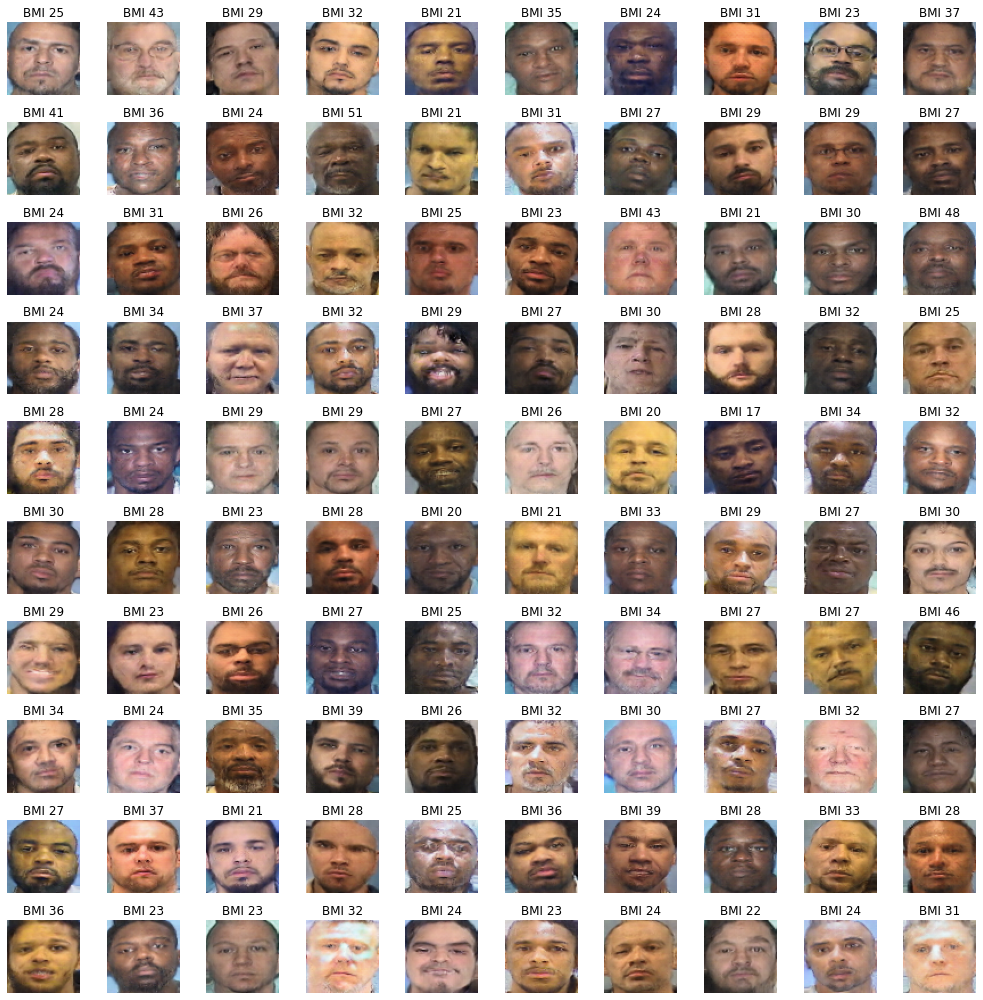

In [ ]:
# same image grid
figure = generate_image_grid(generator)
# save the figure
figure.savefig('path/image_grids/image_grid_epoch_final.png')